In [1]:
import sys
import os
import numpy as np
import lal
import h5py as h5
import lalsimulation as lalsim
import bilby

import copy
import time
import sys
sys.path.append("..")
import importlib
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt

import gwfast.gwfastUtils as utils
import gwfast.gwfastGlobals as glob
import gwfast.waveforms as WF
import gwfast.signal as signal
import gwfast.network as network

TEOBResumS is not installed, only the GWFAST waveform models are available, namely: TaylorF2, IMRPhenomD, IMRPhenomD_NRTidalv2, IMRPhenomHM and IMRPhenomNSBH


In [2]:
binary = {
    'mass_1_detector' : 38.9185650890623,     # Mass of larger BH
    'mass_2_detector' : 33.458613972262064,   # Mass of smaller BH
    'theta_jn'        : 2.67548653,
    'inclination'     : 2.67548653,
    'chi_1z'          : 0.27210419,
    'chi_2z'          : 0.33355909,
    'distance'        : 439.29,               # Distance in Mpc
    'dec'             : -1.2148064804269771,  # Declination
    'ra'              : 1.6768742520431272,   # Right ascension
    'psi'             : 0.78539816,           # Polarization
    'geocent_time'    : 1.1262594624e+09,     # Geocentric time (keep at 1)
    'phase'           : 0.1,   
    'f_ref'           : 20.0,                 # Reference frequency (Hz)
    'f_min'           : 20.0,                 # Minimum frequency (Hz)
    'waveform'        : 'IMRPhenomD'          # Waveform approximant to inject
}

binary['z'] = bilby.gw.conversion.luminosity_distance_to_redshift(binary['distance'])
binary['q'] = min(binary['mass_1_detector'], binary['mass_2_detector'])/(max(binary['mass_1_detector'], binary['mass_2_detector']))
binary['total_mass_detector'] = binary['mass_1_detector'] + binary['mass_2_detector'] 
q = binary['q']

In [3]:
def get_duration(b):
    '''
    Get segment length to use as nice power of 2
    '''
    log                 = np.log2(b)
    integer_power_below = 2 ** np.floor(log)
    integer_power_above = 2 ** np.ceil(log)
    midpoint            = (integer_power_below + integer_power_above) / 2
    ret_val             = 2 ** np.ceil(log)
   
    if(ret_val < 4): ret_val = 4

    return ret_val

binary['chirp_time'] = lalsim.SimIMRPhenomDChirpTime(binary['mass_1_detector']*lal.MSUN_SI,
                                                              binary['mass_2_detector']*lal.MSUN_SI,
                                                              binary['chi_1z'],
                                                              binary['chi_2z'],
                                                              binary['f_min']
                                                             )

In [6]:
settings = {
'ifos'  : ['H1','L1','V1'], # Initialise detector network using default PSDs (O4 high [check])
'srate' : 2048.}
settings['f_max'] = settings['srate'] / 2 # Maximum frequency from nyquist ~ srate / 2
settings['f_min'] = binary['f_min']
settings['seglen'] = get_duration(binary['chirp_time'] + 2.0)
settings['start_time'] = binary['geocent_time'] + 2 - settings['seglen']

ifos  = bilby.gw.detector.InterferometerList(settings['ifos'])
nifos = len(settings['ifos'])
ifos

[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/alex/anaconda3/envs/myenv/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05),
 Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/alex/anaconda3/envs/myenv/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=30.562894333333332, longitude=-90.77424038888887, elevation=-6.574, xarm_azimuth=197.7165, yarm_azimuth=287.7165, xarm_tilt=-0.0003121, yarm_tilt=-0.0006107),
 Interferometer(name='V1', power_spectral_density=PowerSpectralDensity(psd_file='/home/alex/anaconda3/envs/myenv

In [7]:
# Sets the PSD to be used in evaluating likelihood
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=settings['srate'], duration=settings['seglen'],
    start_time=settings['start_time'])

In [8]:
injection_parameters = dict(
    mass_1   = binary['mass_1_detector'],
    mass_2   = binary['mass_2_detector'],
    chi_1    = binary['chi_1z'],
    chi_2    = binary['chi_2z'],
    a_1      = binary['chi_1z'],
    a_2      = binary['chi_2z'],
    tilt_1   = 0.,
    tilt_2   = 0.,
    phi_12   = 0.,
    phi_jl   = 0.,
    theta_jn = binary['theta_jn'],
    psi      = binary['psi'],
    phase    = binary['phase'],
    ra       = binary['ra'],
    dec      = binary['dec'],
    luminosity_distance = binary['distance'],
    geocent_time        = binary['geocent_time']
    )

In [9]:
injected_waveform_arguments = \
dict(waveform_approximant = binary['waveform'],
     reference_frequency  = binary['f_ref'],
     minimum_frequency    = settings['f_min'])

In [10]:
conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
injected_waveform_generator = bilby.gw.WaveformGenerator(
    duration                      = settings['seglen'],
    sampling_frequency            = settings['srate'],
    parameter_conversion          = conversion,
    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
    waveform_arguments            = injected_waveform_arguments
)

ifos.inject_signal(waveform_generator=injected_waveform_generator,
                   parameters=injection_parameters)

10:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
10:20 bilby INFO    : Injected signal in H1:
10:20 bilby INFO    :   optimal SNR = 62.74
10:20 bilby INFO    :   matched filter SNR = 62.74+0.00j
10:20 bilby INFO    :   mass_1 = 38.9185650890623
10:20 bilby INFO    :   mass_2 = 33.458613972262064
10:20 bilby INFO    :   chi_1 = 0.27210419
10:20 bilby INFO    :   chi_2 = 0.33355909
10:20 bilby INFO    :   a_1 = 0.27210419
10:20 bilby INFO    :   a_2 = 0.33355909
10:20 bilby INFO    :   tilt_1 = 0.0
10:20 bilby INFO    :   tilt_2 = 0.0
10:20 bilby INFO    :   phi_12 = 0.0
10:20 bilby INFO    :   phi_jl = 0.0
10:20 bilby INFO    :   theta_jn = 2.67548653
10:20 bilby INFO    :   psi = 0.78539816
10:20 bilby INFO    :   phase = 0.1
10:20 bilby INFO    :   ra = 1.6768742520431272
10:20 bilby INFO 

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [12]:
""" 
Setup priors for likelihood

Remarks
-------

(1) Use cosine instead of sine for dec because of relationship between dec and theta

"""
# 'mass_ratio' : bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.125, maximum=1),
# 'chirp_mass' : bilby.prior.analytical.Uniform(name='chirp_mass', minimum=10, maximum=80),
# 'mass_ratio' : bilby.prior.analytical.Uniform(name='mass_ratio', minimum=0.125, maximum=1),
# 'chirp_mass' : bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=10, maximum=80),
# 'mass_1'     : bilby.gw.prior.Constraint(name='mass_1', minimum=5, maximum=100),
# 'mass_2'     : bilby.gw.prior.Constraint(name='mass_2', minimum=5, maximum=100),
# 'luminosity_distance' : bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=50, maximum=2e3, unit='Mpc'),

prior = {
'chirp_mass'          : bilby.prior.analytical.Uniform(name='chirp_mass', minimum=10, maximum=80),
'symmetric_mass_ratio': bilby.prior.analytical.Uniform(0.1, 0.25, name='symmetric_mass_ratio'),
'luminosity_distance' : bilby.prior.analytical.Uniform(name='luminosity_distance', minimum=50, maximum=2e3, unit='Mpc'),
'dec'                 : bilby.prior.analytical.Cosine(name='dec'), # (1)
'ra'                  : bilby.prior.analytical.Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
'theta_jn'            : bilby.prior.analytical.Sine(name='theta_jn'),
'psi'                 : bilby.prior.analytical.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
'geocent_time'        : bilby.prior.analytical.Uniform(name='geocent_time', minimum=binary['geocent_time'] - 2, maximum=binary['geocent_time'] + 2),
'phase'               : bilby.prior.analytical.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
'chi_1'               : bilby.gw.prior.AlignedSpin(name='chi_1', a_prior=bilby.prior.analytical.Uniform(minimum=0, maximum=0.99)),
'chi_2'               : bilby.gw.prior.AlignedSpin(name='chi_2', a_prior=bilby.prior.analytical.Uniform(minimum=0, maximum=0.99))
}

In [13]:
""" 
TODO
"""

conversion         = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
waveform_arguments = {
    'waveform_approximant' : binary['waveform'],
    'reference_frequency'  : binary['f_ref'],
    'minimum_frequency'    : settings['f_min']
}

waveform_generator = bilby.gw.WaveformGenerator(
    duration                      = settings['seglen'],
    sampling_frequency            = settings['srate'],
    parameter_conversion          = conversion,
    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
    waveform_arguments            = waveform_arguments
)

10:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [14]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers          = ifos,
    waveform_generator       = waveform_generator,
    priors                   = prior,
    time_marginalization     = False, # Should be safe to use
    distance_marginalization = False, # Safe to use
    phase_marginalization    = False  # Only use if neglecting HM
)

In [20]:
from gwfast.gwfastUtils import m1m2_from_Mceta, GPSt_to_LMST

seconds_per_day = 86400.

def like_wrapper(x):
    """ 
    Remarks
    -------

    (1) tcoal is in units of tgps
    (2) Bilby accepts dL in megaparsecs (1e6), gwfast accepts dL in gigaparsecs (1e9)
    """

    Mc      = x[0]
    eta     = x[1]
    dL      = x[2]
    theta   = x[3]
    phi     = x[4]
    iota    = x[5]
    psi     = x[6]
    tGPS    = x[7]
    Phicoal = x[8]
    chi1z   = x[9]
    chi2z   = x[10]

    mass_1, mass_2 = m1m2_from_Mceta(Mc, eta)

    params = {'mass_1': mass_1,
              'mass_2': mass_2,
              'chi_1': chi1z,
              'chi_2': chi2z,
              'theta_jn': iota,
              'psi': psi,
              'phase': Phicoal,
              'ra': phi,
              'dec': np.pi/2 - theta,
              'luminosity_distance': dL * 1000, # (2)
              'geocent_time': tGPS}
    
    likelihood.parameters = params 
    return likelihood.log_likelihood() #+ likelihood.prior.ln_prob()

def ln_prior(x):
    """ 
    Remarks
    -------
    
    (1) Change dL from units of Gpc to Mpc
    (2) Change theta to declination
    """
    x[2] = x[2] * 1000     # (1)
    x[3] = np.pi/2 - x[3]  # (2)
    res = 0
    for i, param in enumerate(likelihood.priors):
        if likelihood.priors[param].ln_prob(x[i]) == - np.inf:
            print(param) 
        res += likelihood.priors[param].ln_prob(x[i])
    return res

def ln_posterior(x):
    return like_wrapper(x) + ln_prior(x)

In [ ]:
likelihood.parameters = injection_parameters
likelihood.parameters

In [16]:
from models.GWFAST_heterodyne import gwfast_class
from jax.config import config
config.update("jax_enable_x64", True)
model = gwfast_class(chi=1, eps=0.5, mode='IMRPhenomD')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using detectors ['L1', 'H1', 'Virgo']
Using waveform model: IMRPhenomD
nbins_standard=2000
nbins_dense=100000
Precomputing squared SNR for likelihood
SNR: 91.402384


In [18]:
import copy
n = 1
x_for_gwfast = model._newDrawFromPrior(1)
x_for_gwfast[0,7] = model.injParams['tcoal']

tGPS_inj = np.array([1.1262594624e+09])[0]
x_for_bilby = copy.deepcopy(x_for_gwfast).squeeze()
x_for_bilby[7] = tGPS_inj

buffer in prior: 0.396000


In [24]:
# ln_posterior(x_for_bilby)
x_for_bilby



array([ 3.46888656e+01,  2.15423970e-01,  1.57264029e+12,  2.21920336e+00,
        2.66764763e+00,  1.06590266e+00,  1.16830452e+00,  1.12625946e+09,
       -1.75601819e+00,  4.22375163e-01,  2.59446239e-01])

In [31]:
test1 = like_wrapper(x_for_bilby)
test2 = -model.standard_minusLogLikelihood(x_for_gwfast)
print(test1, test2)

-4276.41963349914 [-4224.82973355]


In [33]:


def getCrossSection(self, a, b, func, ngrid):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(self.priorDict[a][0], self.priorDict[a][1], ngrid)
    y = np.linspace(self.priorDict[b][0], self.priorDict[b][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, self.DoF))
    index1 = self.gwfast_param_order.index(a)
    index2 = self.gwfast_param_order.index(b)
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(self.DoF): # Fix all other parameters
        if i != index1 and i != index2:
            if i != 7:
                particle_grid[:, i] = np.ones(ngrid ** 2) * self.true_params[i]
            else:
                particle_grid[:, i] = np.ones(ngrid ** 2) * tGPS_inj
    # Z = np.exp(-1 * func(particle_grid).reshape(ngrid,ngrid))
    Z = func(particle_grid).reshape(ngrid,ngrid)
    # s = self.getGradientMinusLogPosterior_ensemble(particle_grid)
    # Z = np.linalg.norm(s,axis=1).reshape(ngrid,ngrid)
    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    # cbar = fig.colorbar(cp)
    plt.colorbar(cp)
    ax.set_xlabel(a)
    ax.set_ylabel(b)
    ax.set_title('Likelihood cross section')
    filename = a + b + 'bilby' + '.png'
    path = os.path.join('marginals', filename)
    fig.savefig(path)

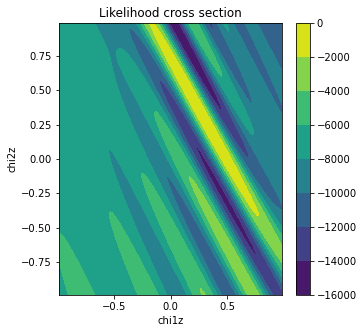

In [40]:
likes = lambda X: np.apply_along_axis(like_wrapper, axis=1, arr=X)
a = 'chi1z'
b = 'chi2z'
getCrossSection(model, a, b, likes, 100)

In [ ]:
n = 100





In [23]:
x = model.true_params[np.newaxis,:]
test_1 = model.standard_minusLogLikelihood(x)
test_2 = likelihood.log_likelihood()
(test_1 - test_2) / test_2 * 100

Array([-100.], dtype=float64)

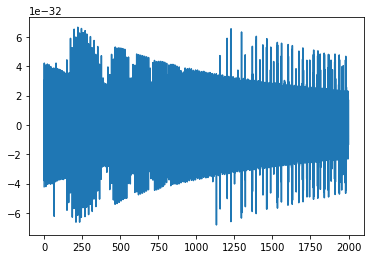

In [6]:
import numpy as np
import matplotlib.pyplot as plt
res_data = np.loadtxt('/mnt/c/sSVN_GW/notebooks/res_data.txt')
fig, ax = plt.subplots()
ax.plot(res_data)
fig.show()

In [ ]:
path = '/home/alex/anaconda3/envs/myenv/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt'
data = np.loadtxt(path)
data[:,1] = np.sqrt(data[:,1])
save_path = '/mnt/c/sSVN_GW/notebooks'
filename = 'AdV_ASD.txt'
np.savetxt(os.path.join(save_path, filename), data)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
asd_data = np.loadtxt(os.path.join(save_path, filename))
ax.loglog(asd_data[:,0], asd_data[:,1], label='Virgo ASD')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('')
ax.set_title('Amplitude spectral density (ASD)')
ax.legend()
fig.show()

## Test with gwfast

In [ ]:
alldetectors = copy.deepcopy(glob.detectors)
# select only LIGO and Virgo
LVdetectors = {det:alldetectors[det] for det in ['L1', 'H1', 'Virgo']}
print('Using detectors '+str(list(LVdetectors.keys())))

In [ ]:
LVdetectors['L1']['psd_path'] = '/Users/francesco.iacovelli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'
LVdetectors['H1']['psd_path'] = '/Users/francesco.iacovelli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'
LVdetectors['Virgo']['psd_path'] = '/Users/francesco.iacovelli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt'

In [ ]:
myLVSignals = {}
is_asd_use=True
mywf = WF.IMRPhenomD()
for d in LVdetectors.keys():
    if d =='Virgo':
        is_asd_use=False
    myLVSignals[d] = signal.GWSignal(mywf, 
                psd_path=LVdetectors[d]['psd_path'],
                detector_shape = LVdetectors[d]['shape'],
                det_lat= LVdetectors[d]['lat'],
                det_long=LVdetectors[d]['long'],
                det_xax=LVdetectors[d]['xax'], 
                verbose=False,
                useEarthMotion = False,
                fmin=20.,
                fmax=2048.,
                is_ASD=is_asd_use,
                IntTablePath=None) 
        
myLVNet = network.DetNet(myLVSignals)   

In [ ]:
injParams = {}
# GW150914
tGPS = np.array([1.1262594624e+09])
tcoal = float(utils.GPSt_to_LMST(tGPS, lat=0., long=0.)) # [0, 1] 
injParams['Mc']      = np.array([31.39])          # (1)   # (0)               # [M_solar]
injParams['eta']     = np.array([0.2485773])           # (2)   # (1)               # [Unitless]
# injParams['dL']      = np.array([2.634])               # (3)   # (2)               # [Gigaparsecs]
injParams['dL']      = np.array([0.43929])               # (3)   # (2)               # [Gigaparsecs]
injParams['theta']   = np.array([2.78560281])          # (4)   # (3)               # [Rad]
injParams['phi']     = np.array([1.67687425])          # (5)   # (4)   RA            # [Rad]
injParams['iota']    = np.array([2.67548653])          # (6)   # (5)               # [Rad]
injParams['psi']     = np.array([0.78539816])          # (7)   # (6)               # [Rad]
injParams['tcoal']   = np.array([tcoal])               # (8)   # (7)               # [sec]
injParams['Phicoal'] = np.array([0.1])                 # (9)   # (8)               # [Rad]
injParams['chi1z']   = np.array([0.27210419])          # (10)  # (9)               # [Unitless]
injParams['chi2z']   = np.array([0.33355909])          # (11)  # (10)              # [Unitless]


In [ ]:
myLVNet.SNR(injParams, return_all=True)